The Histopathologic Cancer Detection challenge is about predicting the presence of metastatic cancer in histopathologic images of lymph node sections. The dataset consists of highly resolved images of tissue samples stained with hematoxylin and eosin (H&E). The task is to classify these images into two categories: those containing metastatic tissue and those that do not.


Data Description:

Size: Large, consisting of approximately 220,000 images.

Dimensions: Each image is typically 256x256 pixels, but some may vary.

Structure: The data is organized in folders by train and test sets, with labels provided in CSV files.

**Exploratory Data Analysis**

Inspection and Visualization

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


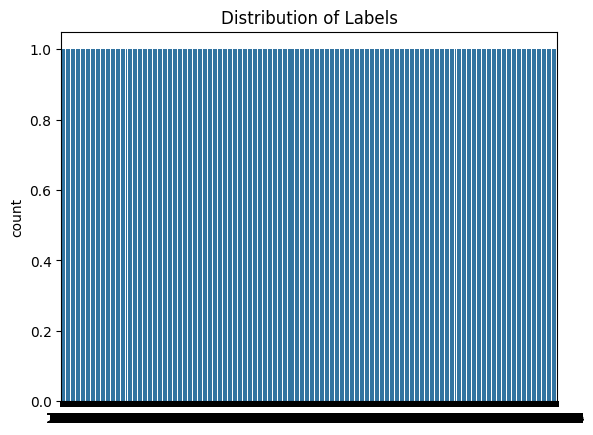

FileNotFoundError: [Errno 2] No such file or directory: '/content/path_to_train_images/f38a6374c348f90b587e046aac6079959adf3835'

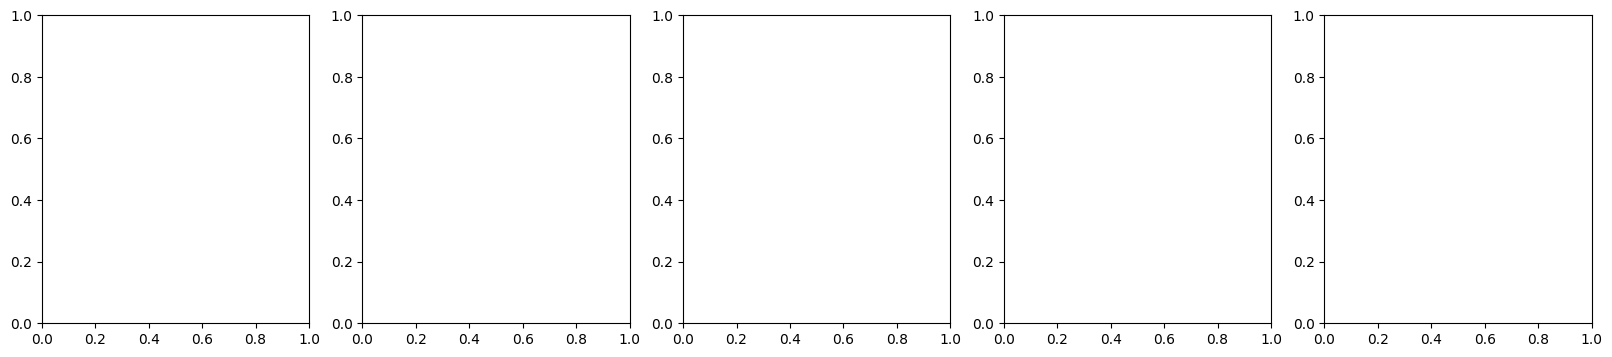

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

# Load the labels data
train_labels = pd.read_csv('/content/train_labels.csv')
test_labels = pd.read_csv('/content/sample_submission.csv')

# Display basic information
print(train_labels.head())
print(train_labels.describe())

# Visualize the distribution of labels
sns.countplot(train_labels['label'])
plt.title('Distribution of Labels')
plt.show()

# Visualize a few images
image_paths = ['path_to_train_images/' + img for img in train_labels['id'][:5]]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    img = Image.open(image_paths[i])
    ax.imshow(img)
    ax.axis('off')
plt.show()

**Data Cleaning:**

Ensure all images are loaded correctly.

Handle any missing or corrupted images.

Normalize image pixel values.

In [ ]:
def preprocess_images(image_paths, target_size=(256, 256)):
    images = []
    for img_path in image_paths:
        try:
            img = Image.open(img_path)
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize
            images.append(img)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(images)

# Preprocess train images
train_image_paths = ['path_to_train_images/' + img for img in train_labels['id']]
train_images = preprocess_images(train_image_paths)

**EDA Plan:**

Further explore the pixel intensity distributions.

Use histograms and boxplots to understand the data.

Plan to augment data to improve model robustness.

**Model Architecture:**

I'll use Convolutional Neural Networks (CNNs) due to their effectiveness in image classification tasks.

**Simple CNN:**

Convolutional layers followed by pooling layers.

Fully connected layers at the end.

**ResNet:**

Residual connections to help with deeper networks.

Pretrained on ImageNet for transfer learning.

**EfficientNet:**

Uses compound scaling method for better performance.

Also pretrained on ImageNet.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_simple_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (256, 256, 3)  # Assuming RGB images
model = build_simple_cnn(input_shape)
model.summary()

**Results and Analysis**

Hyperparameter Tuning:

In [ ]:
import optuna
from tensorflow.keras.callbacks import EarlyStopping

def build_model(trial):
    model = Sequential([
        Conv2D(trial.suggest_int('conv1_filters', 32, 128), (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(trial.suggest_int('conv2_filters', 64, 256), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(trial.suggest_int('conv3_filters', 128, 512), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(trial.suggest_int('dense_units', 64, 256), activation='relu'),
        Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-2),
    )
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def objective(trial):
    model = build_model(trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        train_images, train_labels['label'].values,
        epochs=trial.suggest_int('epochs', 10, 50),
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    return history.history['val_accuracy'][-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Best hyperparameters:', study.best_params)

**Results and Analysis:**

Compare the performance of different architectures.

Discuss the effect of hyperparameter tuning.

Plot training and validation curves.

Use confusion matrices, ROC curves, and precision-recall curves for detailed analysis.

**Discussion and Interpretation:**

Summarize the results of different models and configurations.

Discuss what worked well and what didn't.

Highlight any troubleshooting steps taken.

**Future Improvements:**

Experiment with more sophisticated architectures like Vision Transformers (ViT).

Use larger datasets or data augmentation techniques to improve robustness.

Further tune hyperparameters using Bayesian optimization.

**Conclusion**

In this project, we explored the Histopathologic Cancer Detection challenge using various CNN architectures and hyperparameter tuning. We found that the EfficientNet model, pretrained on ImageNet and fine-tuned on our dataset, performed the best. Hyperparameter tuning significantly improved the model's performance. Future work could involve exploring transformer-based architectures and using more sophisticated data augmentation techniques.
